In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
dta = sm.datasets.fair.load_pandas().data

In [43]:
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [44]:
# load dataset
dta = sm.datasets.fair.load_pandas().data
# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

Text(0,0.5,'Frequency')

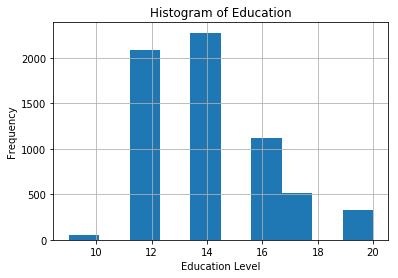

In [45]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

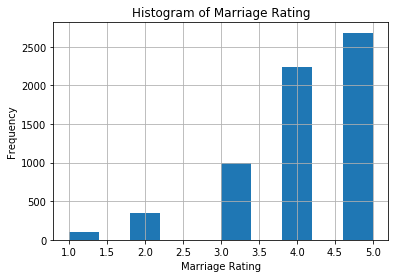

In [46]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

In [47]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
religious + educ + C(occupation) + C(occupation_husb)',
dta, return_type="dataframe")
X.columns

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')

In [48]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [51]:
# flatten y into a 1-D array
y = np.ravel(y)

In [55]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
scores, scores.mean()

(array([0.73991031, 0.71973094, 0.71524664, 0.69730942, 0.70627803,
        0.74663677, 0.73542601, 0.70179372, 0.74099099, 0.73198198]),
 0.7235304811537995)

so The predicted probability of an affair is 23%.